In [10]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import json
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Generic methods to convert json format to DataFrame

In [54]:
def compute_metrics(data : dict):
    oc_list = list()
    available_list = list()
    prev_available_list = list()
    deltabooked_list = list()
    correction_list = list()
    percentile_list = list()
    prev_percentile_list = list()
    config_list = list()
    prev_booked = 0
    prev_available = 0
    prev_percentile = 0
    for index in range(len(data["epoch"])):
        available = data["model"]["free_cpu"][index]
        config = data['node']["cpu_config"][index]
        ratio = (data['node']["booked_cpu"][index] + data["model"]["free_cpu"][index])/data['node']["cpu_config"][index]
        percentile = data['node']['cpu_percentile'][index]['99'] 
        delta_booked = data['node']["booked_cpu"][index] - prev_booked
        oc_list.append(ratio)
        available_list.append(available)
        prev_available_list.append(prev_available)
        deltabooked_list.append(delta_booked)
        if delta_booked>=0:
            correction_list.append(delta_booked)
        else:
            correction_list.append(percentile - prev_percentile)
        percentile_list.append(percentile)
        prev_percentile_list.append(prev_percentile)
        config_list.append(config)
        prev_available = available
        prev_percentile = percentile
        prev_booked = data['node']["booked_cpu"][index]
    return oc_list, available_list, prev_available_list, deltabooked_list, correction_list, percentile_list, prev_percentile_list, config_list

def add_line(dict_to_use : dict, curr_strategy, curr_iteration, oc_ratio, available, prev_available, delta_booked, correction, percentile, prev_percentile, config):
    dict_to_use["strategy"].append(curr_strategy)
    dict_to_use["iteration"].append(curr_iteration)
    dict_to_use["ratio"].append(oc_ratio)
    dict_to_use["available"].append(available)
    dict_to_use["prev_available"].append(prev_available)
    dict_to_use["delta_booked"].append(delta_booked)
    dict_to_use["correction"].append(correction)
    dict_to_use["percentile"].append(percentile)
    dict_to_use["prev_percentile"].append(prev_percentile)
    dict_to_use["config"].append(config)

def load_folder(folder : str):
    input_strat = dict()
    strategies = ['borg', 'doa', 'greedy', 'maxpeak', 'nsigma', 'percentile', 'rclike']
    #strategies = ['percentile']
    for strategy in strategies:
        input_strat[strategy] = folder + "/dump-" + strategy + ".json"
    
    compare_strat_dict = dict()
    compare_strat_dict["iteration"] = list()
    compare_strat_dict["strategy"] = list()
    compare_strat_dict["ratio"] = list()
    compare_strat_dict["available"] = list()
    compare_strat_dict["prev_available"] = list()
    compare_strat_dict["percentile"] = list()
    compare_strat_dict["delta_booked"] = list()
    compare_strat_dict["correction"] = list()
    compare_strat_dict["prev_percentile"] = list()
    compare_strat_dict["config"] = list()
    
    for strat, file in input_strat.items():
        print("Loading", strat, file)
        with open(file, 'r') as f:
            targeted_data = json.load(f)
        oc_list, available_list, prev_available_list, deltabooked_list, correction_list, percentile_list, prev_percentile_list, config_list = compute_metrics(targeted_data)
        for iteration_curr in range(len(oc_list)):
            add_line(compare_strat_dict, strat, iteration_curr, oc_list[iteration_curr], available_list[iteration_curr], prev_available_list[iteration_curr], deltabooked_list[iteration_curr], correction_list[iteration_curr], percentile_list[iteration_curr], prev_percentile_list[iteration_curr], config_list[iteration_curr])
    print("Done")
    
    return compare_strat_dict

# Load the "decreasing workload" trace

In [101]:
folder = "/usr/local/src/scroogevm/dump-decrease"

decreasing_df = pd.DataFrame(load_folder(folder))

Loading borg /usr/local/src/scroogevm/dump-decrease/dump-borg.json
Loading doa /usr/local/src/scroogevm/dump-decrease/dump-doa.json
Loading greedy /usr/local/src/scroogevm/dump-decrease/dump-greedy.json
Loading maxpeak /usr/local/src/scroogevm/dump-decrease/dump-maxpeak.json
Loading nsigma /usr/local/src/scroogevm/dump-decrease/dump-nsigma.json
Loading percentile /usr/local/src/scroogevm/dump-decrease/dump-percentile.json
Loading rclike /usr/local/src/scroogevm/dump-decrease/dump-rclike.json
Done


In [102]:
decreasing_df = decreasing_df.loc[decreasing_df["iteration"] < 34]
decreasing_df = decreasing_df.loc[decreasing_df["iteration"] > 0]

decreasing_df["prev_available_corrected"] = decreasing_df["prev_available"] - decreasing_df["correction"]
decreasing_df["available_groundthruth"] = decreasing_df["config"] - decreasing_df["percentile"]
decreasing_df["delta_available"] = decreasing_df["available"] - decreasing_df["prev_available_corrected"]

decreasing_df["current_available_misprediction"] = decreasing_df["available_groundthruth"] - decreasing_df["prev_available_corrected"]
decreasing_df["current_available_misprediction%"] = decreasing_df["current_available_misprediction"] / decreasing_df["config"]

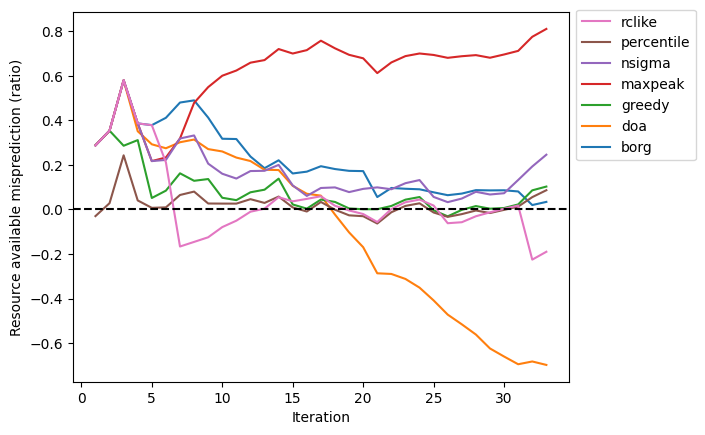

In [103]:
#hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)

sns.lineplot(data=decreasing_df, x="iteration", y="current_available_misprediction%", hue="strategy") #, palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.legend(ncol=1, loc="lower right", frameon=True, reverse=True, bbox_to_anchor=(1.27, 0.58))
x = plt.ylabel('Resource available misprediction (ratio)')

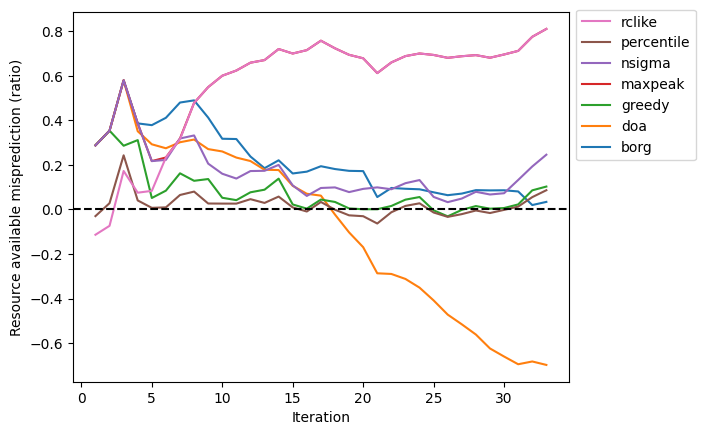

In [69]:
#hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)

sns.lineplot(data=decreasing_df, x="iteration", y="current_available_misprediction%", hue="strategy") #, palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.legend(ncol=1, loc="lower right", frameon=True, reverse=True, bbox_to_anchor=(1.27, 0.58))
x = plt.ylabel('Resource available misprediction (ratio)')

Strategy borg negative variation count: 9 average: -6.093115493475826 max -17.51801396399481
Strategy doa negative variation count: 3 average: -4.401528314759176 max -6.9180139639948095
Strategy greedy negative variation count: 16 average: -6.262209014769562 max -19.91801396399481
Strategy maxpeak negative variation count: 18 average: -10.717699456615541 max -40.897506542982406
Strategy nsigma negative variation count: 17 average: -6.825151223004443 max -24.618013963994812
Strategy percentile negative variation count: 13 average: -6.290673362705254 max -14.21801396399482
Strategy rclike negative variation count: 19 average: -12.064136327319986 max -41.6975065429824


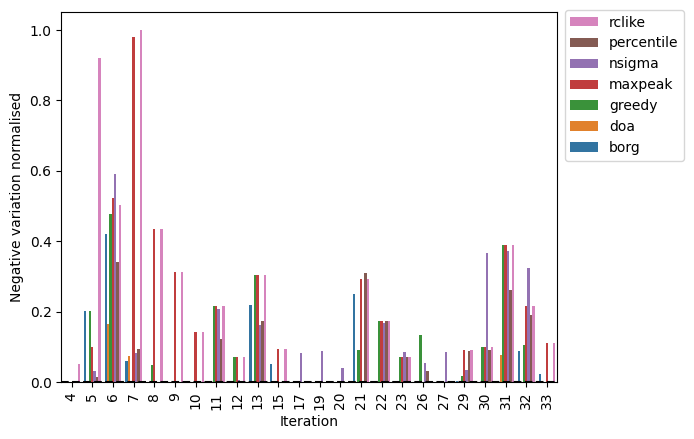

In [95]:
pd.options.mode.chained_assignment = None 
filter_df = decreasing_df.loc[decreasing_df['delta_available'] < 0]
min_val = filter_df['delta_available'].min()
max_val = filter_df['delta_available'].max()
filter_df['delta_available_norm'] = filter_df['delta_available'].apply(lambda x : (x - max_val) / (min_val - max_val))

sns.barplot(data=filter_df, x="iteration", y="delta_available_norm", hue="strategy")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.legend(ncol=1, loc="lower right", frameon=True, reverse=True, bbox_to_anchor=(1.27, 0.58))
x = plt.ylabel('Negative variation normalised')
x = plt.xticks(rotation=90)

strategies = decreasing_df['strategy'].unique()
for strategy in strategies:
    filter_strategy_df = filter_df.loc[filter_df['strategy'] ==  strategy]
    st_mean = filter_strategy_df['delta_available'].mean()
    st_max = filter_strategy_df['delta_available'].min()
    print("Strategy", strategy, "negative variation count:", len(filter_strategy_df), "average:", st_mean, "max", st_max)

In [44]:
t = decreasing_df.loc[decreasing_df['strategy'] == 'greedy']
t.tail(n=20)

,iteration,strategy,ratio,available,prev_available,percentile,delta_booked,correction,prev_percentile,config,prev_available_corrected,available_groundthruth,current_available_misprediction,current_available_misprediction%
220,14,greedy,1.185156,173.4,148.9,76.903040,-11.0,5.153623,71.749418,256.0,143.746377,179.096960,35.350582,0.138088
221,15,greedy,1.211328,182.1,173.4,73.004773,-2.0,-3.898268,76.903040,256.0,177.298268,182.995227,5.696960,0.022254
222,16,greedy,1.193359,182.5,182.1,76.952783,-5.0,3.948010,73.004773,256.0,178.151990,179.047217,0.895227,0.003497
223,17,greedy,1.201172,178.5,182.5,68.164933,6.0,6.000000,76.952783,256.0,176.500000,187.835067,11.335067,0.044278
224,18,greedy,1.228516,179.5,178.5,76.920226,6.0,6.000000,68.164933,256.0,172.500000,179.079774,6.579774,0.025702
225,19,greedy,1.228125,175.4,179.5,82.391462,4.0,4.000000,76.920226,256.0,175.500000,173.608538,-1.891462,-0.007389
226,20,greedy,1.096094,155.6,175.4,99.383284,-14.0,16.991821,82.391462,256.0,158.408179,156.616716,-1.791462,-0.006998
227,21,greedy,1.124609,164.9,155.6,87.137245,-2.0,-12.246039,99.383284,256.0,167.846039,168.862755,1.016716,0.003972
228,22,greedy,1.089453,164.9,164.9,79.868659,-9.0,-7.268586,87.137245,256.0,172.168586,176.131341,3.962755,0.015480
229,23,greedy,1.073828,164.9,164.9,76.866931,-4.0,-3.001728,79.868659,256.0,167.901728,179.133069,11.231341,0.043872


# Load the "increasing workload" trace

In [70]:
folder = "/usr/local/src/scroogevm/dump-increase"

increasing_df = pd.DataFrame(load_folder(folder))

Loading borg /usr/local/src/scroogevm/dump-increase/dump-borg.json
Loading doa /usr/local/src/scroogevm/dump-increase/dump-doa.json
Loading greedy /usr/local/src/scroogevm/dump-increase/dump-greedy.json
Loading maxpeak /usr/local/src/scroogevm/dump-increase/dump-maxpeak.json
Loading nsigma /usr/local/src/scroogevm/dump-increase/dump-nsigma.json
Loading percentile /usr/local/src/scroogevm/dump-increase/dump-percentile.json
Loading rclike /usr/local/src/scroogevm/dump-increase/dump-rclike.json
Done


In [99]:
increasing_df = increasing_df.loc[increasing_df["iteration"] < 34]
increasing_df = increasing_df.loc[increasing_df["iteration"] > 0]

increasing_df["prev_available_corrected"] = increasing_df["prev_available"] - increasing_df["correction"]
increasing_df["delta_available"] = increasing_df["available"] - increasing_df["prev_available_corrected"]
increasing_df["current_available"] = increasing_df["config"] - increasing_df["percentile"]

increasing_df["current_available_misprediction"] = increasing_df["current_available"] - increasing_df["prev_available_corrected"]
increasing_df["current_available_misprediction%"] = increasing_df["current_available_misprediction"] / increasing_df["config"]

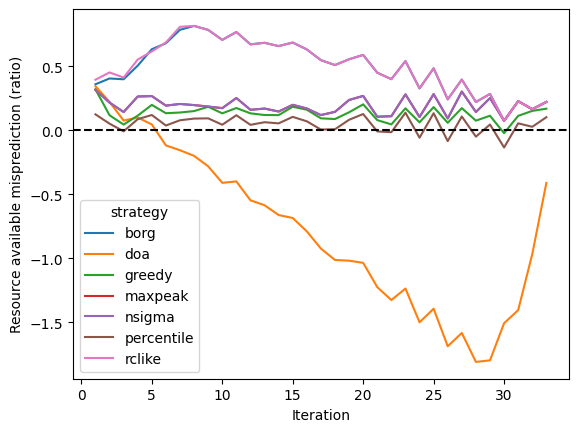

In [72]:
#hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)

sns.lineplot(data=increasing_df, x="iteration", y="current_available_misprediction%", hue="strategy") # , palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.ylabel('Resource available misprediction (ratio)')

Strategy borg negative variation count: 0 average: nan max nan
Strategy doa negative variation count: 4 average: -86.0 max -102.0
Strategy greedy negative variation count: 0 average: nan max nan
Strategy maxpeak negative variation count: 2 average: -1.600000000000005 max -2.9000000000000057
Strategy nsigma negative variation count: 2 average: -1.600000000000005 max -2.9000000000000057
Strategy percentile negative variation count: 1 average: -7.0 max -7.0
Strategy rclike negative variation count: 3 average: -4.0 max -8.0


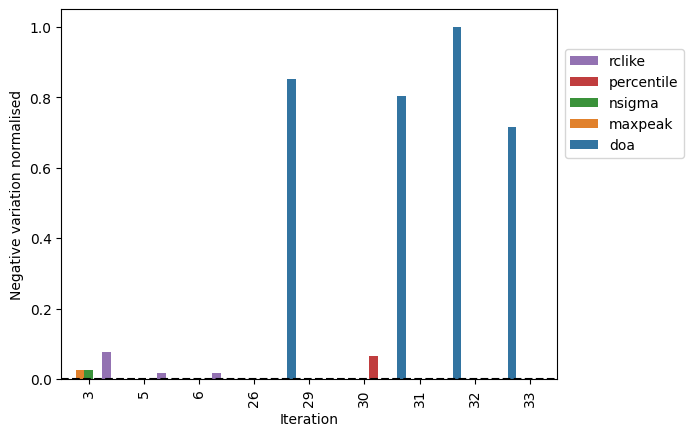

In [100]:
pd.options.mode.chained_assignment = None 
filter_df = increasing_df.loc[increasing_df['delta_available'] < 0]
min_val = filter_df['delta_available'].min()
max_val = filter_df['delta_available'].max()
filter_df['delta_available_norm'] = filter_df['delta_available'].apply(lambda x : (x - max_val) / (min_val - max_val))

sns.barplot(data=filter_df, x="iteration", y="delta_available_norm", hue="strategy")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.legend(ncol=1, loc="lower right", frameon=True, reverse=True, bbox_to_anchor=(1.27, 0.58))
x = plt.ylabel('Negative variation normalised')
x = plt.xticks(rotation=90)

strategies = decreasing_df['strategy'].unique()
for strategy in strategies:
    filter_strategy_df = filter_df.loc[filter_df['strategy'] ==  strategy]
    st_mean = filter_strategy_df['delta_available'].mean()
    st_max = filter_strategy_df['delta_available'].min()
    print("Strategy", strategy, "negative variation count:", len(filter_strategy_df), "average:", st_mean, "max", st_max)

In [87]:
t = increasing_df.loc[increasing_df['strategy'] == 'rclike']
t.tail(n=20)

,iteration,strategy,ratio,available,prev_available,percentile,delta_booked,correction,prev_percentile,config,prev_available_corrected,current_available,current_available_misprediction,current_available_misprediction%
484,14,rclike,2.751562,175.4,181.8,111.587160,32.0,32.0,103.812682,256.0,149.8,144.412840,-5.387160,-0.021044
485,15,rclike,2.922266,179.1,175.4,115.374877,40.0,40.0,111.587160,256.0,135.4,140.625123,5.225123,0.020411
486,16,rclike,3.023438,168.0,179.1,121.000111,37.0,37.0,115.374877,256.0,142.1,134.999889,-7.100111,-0.027735
487,17,rclike,3.132812,170.0,168.0,134.922890,26.0,26.0,121.000111,256.0,142.0,121.077110,-20.922890,-0.081730
488,18,rclike,3.196875,164.4,170.0,138.868263,22.0,22.0,134.922890,256.0,148.0,117.131737,-30.868263,-0.120579
489,19,rclike,3.303516,156.7,164.4,139.507887,35.0,35.0,138.868263,256.0,129.4,116.492113,-12.907887,-0.050421
490,20,rclike,3.473828,157.3,156.7,138.100216,43.0,43.0,139.507887,256.0,113.7,117.899784,4.199784,0.016405
491,21,rclike,3.545703,152.7,157.3,153.956056,23.0,23.0,138.100216,256.0,134.3,102.043944,-32.256056,-0.126000
492,22,rclike,3.577344,150.8,152.7,156.480914,10.0,10.0,153.956056,256.0,142.7,99.519086,-43.180914,-0.168675
493,23,rclike,3.766016,145.1,150.8,161.079212,54.0,54.0,156.480914,256.0,96.8,94.920788,-1.879212,-0.007341


# Compare both traces on the same board (Paper figure)

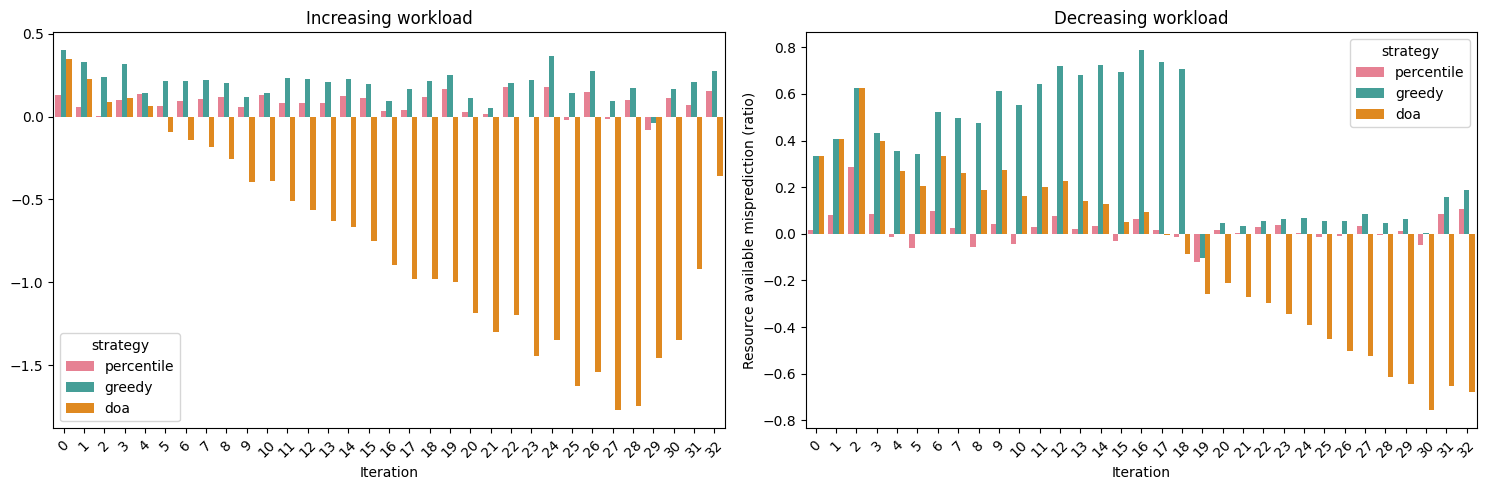

In [46]:
hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 5))


g = sns.barplot(data=compare_df2, x="iteration", y="current_available_misprediction%", hue="strategy",  palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order, ax=ax1)
ax1.set_title("Increasing workload")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("")
x = ax1.set_xticklabels(ax1.get_xticks(), rotation=45)

g = sns.barplot(data=compare_df, x="iteration", y="current_available_misprediction%", hue="strategy", palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order, ax=ax2)
ax2.set_title("Decreasing workload")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Resource available misprediction (ratio)")
x = ax2.set_xticklabels(ax2.get_xticks(), rotation=45)

fig.tight_layout()